## HAM experiment with  classification -> Segmentation

## Installation of libraries

In [1]:
# Install libraries

!pip install torch torchvision tensorboard
!pip install barbar
!pip install torchsummary
!pip install pytorch-ignite
!pip install timm
!pip install opencv-python

In [2]:
import torch
import os
import random
import torchvision
import pandas as pd
import datetime as dt
import torch.nn as nn
import numpy as np
from torchvision import transforms, datasets
from shutil import copyfile, move
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from torch.utils.tensorboard import SummaryWriter
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from barbar import Bar
from torchsummary import summary
from ignite.metrics import Accuracy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score
import timm
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, classification_report
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc

/opt/conda/lib/python3.11/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [3]:
from tqdm import tqdm
from sklearn.manifold import TSNE

In [4]:
args = {
    # Dataset for segmentation (HAM)
    'train_dir_seg': '/home/jovyan/nfs/mgallazzi/datasets/SEGMENTATION_RESNET/images/training/',
    'val_dir_seg': '/home/jovyan/nfs/mgallazzi/datasets/SEGMENTATION_RESNET/images/validation/',
    'test_dir_seg': '/home/jovyan/nfs/mgallazzi/datasets/HAM_test_segmentation/test_images',

    # Masks for segmentation (HAM)
    'mask_dir_train': '/home/jovyan/nfs/mgallazzi/datasets/SEGMENTATION_RESNET/masks/training/',
    'mask_dir_val': '/home/jovyan/nfs/mgallazzi/datasets/SEGMENTATION_RESNET/masks/validation/',
    'mask_dir_test': '/home/jovyan/nfs/mgallazzi/datasets/HAM_test_segmentation/test_masks',

    # Dataset for classification (HAM)
    'train_dir_class': '/home/jovyan/shared/abulgheroni/datasets/HAM10k_duplicatiTranneNV/training/',
    'val_dir_class': '/home/jovyan/shared/abulgheroni/datasets/HAM10k_duplicatiTranneNV/validation/',  
    'test_dir_class': '/home/jovyan/nfs/mgallazzi/datasets/HAM10k_test_Duplicati/divided/',

    'save_dir': 'experiments/1.3.2.Swin_class+seg_NOconcatenazione_dataset(run_binary_training)_val+test_seg',
    'num_classes': 7,  # Number of class for classification
    'lambda_multi': 1.0,  # weight for multiclass-loss
    'lambda_bin': 1.0,  # weight for binary-loss
    'batch_size': 128,  # Batch size for training
    'early_stopping': 20,  # Number of epochs for early stopping
    'lr': 0.0001,  # Learning rate
    'alpha': 0.25,  # Specific parameter for the loss weighting
    'device': torch.device("cuda:5" if torch.cuda.is_available() else "cpu"),
}


In [5]:
if os.path.exists(args['save_dir']):
    raise Exception(f"Sorry, the output dir {args['save_dir']} already exists!")  # error...
os.makedirs(args['save_dir'])

In [5]:
class Metrics:
    def __init__(self, column_names):
        column_names.insert(0, "time_stamp")
        self.df = pd.DataFrame(columns=column_names)

    def add_row(self, row_list):
        row_list.insert(0, str(dt.datetime.now()))
        # print(row_list)
        self.df.loc[len(self.df)] = row_list

    def save_to_csv(self, filepath):
        self.df.to_csv(filepath, index=False)

    def load(self, filepath):
        # Load data from the CSV file into the DataFrame
        self.df = pd.read_csv(filepath)

    def get_best_value(self, column_name):
        if column_name in self.df.columns:
            return self.df[column_name].max()
        else:
            raise ValueError(f"Column '{column_name}' does not exist in the DataFrame")

    def plot(self, col_names=[], title="", x_label="", y_label="", bottom=None, top=None):
        data2plot = self.df[col_names]
        # ================plot===================
        ax = data2plot.plot(title=title) #figsize=(10,8), 
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        ax.set_ylim(bottom, top)

## Datasets

In [6]:
# Function to count files in a folder by category
def count_files_by_category(base_dir, categories):
    count_by_category = {}
    for category in categories:
        dir_path = os.path.join(base_dir, category)
        count_by_category[category] = len(os.listdir(dir_path))
    return count_by_category

# Function to count all files in a folder (no categories)
def count_total_files(folder):
    return len(os.listdir(folder))

# Define the categories
categories = ['0.MEL', '1.NV', '2.BCC', '3.AKIEC', '4.BKL', '5.DF', '6.VASC']

# Count images and masks for training and validation sets
train_images = count_files_by_category(args['train_dir_seg'], categories)
train_masks = count_files_by_category(args['mask_dir_train'], categories)
val_images = count_files_by_category(args['val_dir_seg'], categories)
val_masks = count_files_by_category(args['mask_dir_val'], categories)
train_classification = count_files_by_category(args['train_dir_class'], categories)
val_classification = count_files_by_category(args['val_dir_class'], categories)
test_classification = count_files_by_category(args['test_dir_class'], categories)

# Create a DataFrame for training and validation sets
df_train_val = pd.DataFrame({
    'Training Images Segmentation': train_images,
    'Training Masks Segmentation': train_masks,
    'Validation Images Segmentation': val_images,
    'Validation Masks Segmentation': val_masks,
    'Training Images Classification': train_classification,
    'Validation Images Classification': val_classification,
    'Test Images Classification': test_classification,
})

# Count images and masks for test set (no categories)
test_images_total = count_total_files(args['test_dir_seg'])
test_masks_total = count_total_files(args['mask_dir_test'])

# Create a separate DataFrame for the test set
df_test = pd.DataFrame({
    'Test Images': [test_images_total],
    'Test Masks': [test_masks_total]
})

# Display the two tables
print("Training and Validation Sets")
display(df_train_val)

print("\nTest Set")
df_test

FileNotFoundError: [Errno 2] No such file or directory: '/home/jovyan/shared/abulgheroni/datasets/HAM10k_duplicatiTranneNV/training/0.MEL'

In [ ]:
# Definizione della mappatura delle classi binarie dove 1:maligne , 0:benigne
class_mapping = {
    '0.MEL': 1, '1.NV': 0, '2.BCC': 1, '3.AKIEC': 1,
    '4.BKL': 0, '5.DF': 0, '6.VASC': 0
}

# Custom Dataset per ImageFolder with binary labels
class BinaryImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None, binary=True, multi=True):
        super(BinaryImageFolder, self).__init__(root, transform=transform)
        self.binary = binary
        self.multiclass = multi
        #self.dataset = datasets.ImageFolder(root, transform=transform)
        self.idx_to_class = {v: k for k, v in self.class_to_idx.items()}
        print("***Loading:" + root)

    def __getitem__(self, index):
        image, label_multiclass = super(BinaryImageFolder, self).__getitem__(index)
        class_name = self.idx_to_class[label_multiclass]
        label_binaria = class_mapping[class_name]
        return image, label_multiclass, label_binaria


class BinaryOnlyImageFolder(datasets.ImageFolder):
    def __init__(self, root, transform=None, binary=True, multi=False):
        super(BinaryOnlyImageFolder, self).__init__(root, transform=transform)
        self.binary = binary
        self.multiclass = multi
        print("***Loading:" + root)

    def __getitem__(self, index):
        image, label_binary = super(BinaryOnlyImageFolder, self).__getitem__(index)
        return image, -1, label_binary


class MyConcatDataset(ConcatDataset):
    def __init__(self, datasets, binary=True, multi=True):
        super(MyConcatDataset, self).__init__(datasets)
        self.binary = binary
        self.multiclass = multi

In [ ]:
class RandomResize:
    def __init__(self, resize_min=224, resize_max=280):
        self.resize_min = resize_min
        self.resize_max = resize_max

    def __call__(self, img):
        # Randomly choose the resize dimensions
        resize_size = random.randint(self.resize_min, self.resize_max)
        resize_transforms = transforms.Resize(resize_size)
        img = resize_transforms(img)
        return img


train_transforms = transforms.Compose([
    RandomResize(224, 280), # transforms.Resize((224, 280)),  # Aumento delle dimensioni a 224x300
    transforms.RandomCrop((224, 224)),  # Applicazione di RandomCrop
    # transforms.Resize((224, 280)),
    # transforms.CenterCrop((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomApply([transforms.RandomAffine(degrees=0, translate=(0.1, 0.1))], p=0.5),  

    # La traslazione sarà casuale con un range di +/-10% rispetto alle dimensioni originali
    transforms.RandomApply(transforms=[transforms.RandomRotation(degrees=(-180, 180))], p=0.99),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

val_transforms = transforms.Compose([
    transforms.Resize((224, 280)),  # Aumento delle dimensioni a 224x300
    transforms.RandomCrop((224, 224)),  # Applicazione di RandomCrop
    # transforms.Resize((224, 280)),
    # torchvision.transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

test_transforms = transforms.Compose([
    transforms.Resize(224), #(224, 300)),  # PERCHE' IL RESIZE E' DIVERSO DAL VAL?
    torchvision.transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def run_test_datasets():
    # Dataset di classificazione per il training
    train_dataset = BinaryImageFolder(
        args['train_dir_class'], transform=train_transforms, binary=True, multi=True)
    
    # Dataset di classificazione per la validazione
    val_dataset = BinaryImageFolder(
        args['val_dir_class'], transform=val_transforms, binary=True, multi=True)
    
    # Dataset di classificazione per il test
    test_dataset = BinaryImageFolder(
        args['test_dir_class'], transform=test_transforms, binary=True, multi=True)

    # Creare DataLoader per classificazione
    train_loader = DataLoader(train_dataset, batch_size=args['batch_size'], shuffle=True, num_workers=8)
    val_loader = DataLoader(val_dataset, batch_size=args['batch_size'], shuffle=False, num_workers=8)
    test_loader = DataLoader(test_dataset, batch_size=args['batch_size'], shuffle=False, num_workers=8)

    return train_loader, val_loader, test_loader

# Esegui la funzione per creare i loader
train_loader, val_loader, test_loader = run_test_datasets()

### Segmentation dataset

In [ ]:
import torchvision.transforms.functional as TF
from PIL import Image

class ComposeTwo(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

class RandomResizeCrop:
    def __init__(self, size=(224,224), resize_min=224, resize_max=280):
        self.size = size
        self.resize_min = resize_min
        self.resize_max = resize_max

    def __call__(self, image, mask):
        new_size = random.randint(self.resize_min, self.resize_max)
        image = TF.resize(image, (new_size, new_size))
        if mask is not None:
            mask = TF.resize(mask, (new_size, new_size), interpolation=Image.NEAREST)
        
        i, j, h, w = transforms.RandomCrop.get_params(image, output_size=self.size)
        image = TF.crop(image, i, j, h, w)
        if mask is not None:
            mask = TF.crop(mask, i, j, h, w)
        return image, mask    

class RandomHorizontalFlip:
    def __init__(self, p=0.5):
        self.p = p

    def __call__(self, image, mask):
        if random.random() < self.p:
            image = TF.hflip(image)
            if mask is not None:
                mask = TF.hflip(mask)
        return image, mask

class RandomAffine:
    def __init__(self, degrees, translate):
        self.degrees = degrees
        self.translate = translate

    def __call__(self, image, mask):
        params = transforms.RandomAffine.get_params(self.degrees, self.translate, None, None, image.size)
        image = TF.affine(image, *params)
        if mask is not None:
            mask = TF.affine(mask, *params)
        return image, mask

class RandomRotation:
    def __init__(self, degrees):
        self.degrees = degrees

    def __call__(self, image, mask):
        angle = random.uniform(self.degrees[0], self.degrees[1])
        image = TF.rotate(image, angle)
        if mask is not None:
            mask = TF.rotate(mask, angle)
        return image, mask

class ToTensorAndNormalize:
    def __init__(self, mean, std):
        self.to_tensor = transforms.ToTensor()
        self.normalize = transforms.Normalize(mean, std)

    def __call__(self, image, mask):
        image = self.to_tensor(image)
        image = self.normalize(image)
        if mask is not None:
            mask = self.to_tensor(mask)
        return image, mask

# Dataset per training e validazione (con sottocartelle)
class CustomSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        """
        Args:
            image_dir (str): Directory con le immagini di input, con sottocartelle.
            mask_dir (str): Directory con le maschere di segmentazione, con sottocartelle.
            transform (callable, optional): Trasformazioni da applicare sia alle immagini di input che alle maschere.
        """
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform

        # Estensioni supportate
        valid_extensions = ('.png', '.bmp', '.jpg', '.jpeg', '.tiff')

        # Cerca immagini e maschere nelle sottocartelle rispettando la stessa struttura
        self.image_filenames = []
        self.mask_filenames = []

        for class_folder in os.listdir(image_dir):
            class_image_folder = os.path.join(image_dir, class_folder)
            class_mask_folder = os.path.join(mask_dir, class_folder)

            # Verifica che le sottocartelle esistano sia per le immagini che per le maschere
            if not os.path.exists(class_mask_folder):
                raise ValueError(f"Missing corresponding mask folder for {class_folder}")

            for image_file in os.listdir(class_image_folder):
                if image_file.endswith(valid_extensions):
                    image_path = os.path.join(class_image_folder, image_file)
                    mask_path = os.path.join(class_mask_folder, image_file.replace('.jpg', '.png'))

                    # Aggiungi solo se esistono sia immagine che maschera
                    if os.path.exists(mask_path):
                        self.image_filenames.append(image_path)
                        self.mask_filenames.append(mask_path)
                    else:
                        print(f"Maschera non trovata per {image_file}, saltata.")

        if len(self.image_filenames) == 0:
            raise ValueError(f"Nessuna immagine trovata nella directory: {image_dir}")
        if len(self.mask_filenames) == 0:
            raise ValueError(f"Nessuna maschera trovata nella directory: {mask_dir}")

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = self.image_filenames[idx]
        mask_path = self.mask_filenames[idx]

        image = Image.open(image_path).convert("RGB")
        mask = Image.open(mask_path).convert("L")  # Converti la maschera in scala di grigi

        if self.transform:
            image, mask = self.transform(image, mask)

        return image, mask

# Dataset for the test set (no subdirectories by class)
class TestImageSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = []
        self.masks = []

        # Load all images and corresponding masks
        for image_file in os.listdir(image_dir):
            # Only consider .jpg files for the images
            if image_file.endswith('.jpg'):
                image_path = os.path.join(image_dir, image_file)

                # The mask file has a .png extension and includes "_segmentation"
                mask_file = image_file.replace('.jpg', '_segmentation.png')
                mask_path = os.path.join(mask_dir, mask_file)

                # Append only if both the image and the mask exist
                if os.path.exists(mask_path):
                    self.images.append(image_path)
                    self.masks.append(mask_path)
                else:
                    print(f"Mask not found for {image_file}, skipping.")

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = Image.open(self.images[idx]).convert("RGB")
        mask = Image.open(self.masks[idx]).convert("L")  # Convert the mask to grayscale

        if self.transform:
            image, mask = self.transform(image, mask)

        return image, mask

In [ ]:
def run_test_seg_dataset():
    # Definire le trasformazioni
    seg_transform = ComposeTwo([
        RandomResizeCrop((224, 224), resize_min=224, resize_max=280),
        RandomHorizontalFlip(p=0.5),
        RandomAffine(degrees=(-10,10), translate=(0.1, 0.1)),
        RandomRotation(degrees=(-180, 180)),
        ToTensorAndNormalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    # Dataset di segmentazione per il training
    train_segmentation_dataset = CustomSegmentationDataset(
        args['train_dir_seg'], args['mask_dir_train'], transform=seg_transform)

    # Dataset di segmentazione per la validazione
    val_segmentation_dataset = CustomSegmentationDataset(
        args['val_dir_seg'], args['mask_dir_val'], transform=seg_transform)

    # Dataset di segmentazione per il test (senza sottocartelle e con "_segmentation" nelle maschere)
    test_segmentation_dataset = TestImageSegmentationDataset(
        args['test_dir_seg'], args['mask_dir_test'], transform=seg_transform)

    # Creare DataLoader per segmentazione
    train_segmentation_loader = DataLoader(train_segmentation_dataset, batch_size=args['batch_size'], shuffle=True, num_workers=8)
    val_segmentation_loader = DataLoader(val_segmentation_dataset, batch_size=args['batch_size'], shuffle=False, num_workers=8)
    test_segmentation_loader = DataLoader(test_segmentation_dataset, batch_size=args['batch_size'], shuffle=False, num_workers=8)

    # Esegui un esempio per verificare la forma delle immagini e delle maschere
    image, mask = train_segmentation_dataset.__getitem__(0)  # Ottieni il primo esempio dal dataset di training
    print(f"Forma dell'immagine (training): {image.shape}")
    print(f"Forma della maschera (training): {mask.shape}")

    image, mask = test_segmentation_dataset.__getitem__(0)  # Ottieni il primo esempio dal dataset di test
    print(f"Forma dell'immagine (test): {image.shape}")
    print(f"Forma della maschera (test): {mask.shape}")

    return train_segmentation_loader, val_segmentation_loader, test_segmentation_loader

# Esegui la funzione per creare i loader di segmentazione e verifica le forme
train_segmentation_loader, val_segmentation_loader, test_segmentation_loader = run_test_seg_dataset()

## Models for classification and segmentation

In [ ]:
from timm.models.layers import SelectAdaptivePool2d
import torch.nn.functional as F

class SwinBase(nn.Module):
    def __init__(self, base_model=None):
        super(SwinBase, self).__init__()
        if base_model is None:
            self.base = timm.create_model('swin_large_patch4_window7_224', pretrained=True)
            self.head_in = self.base.head.in_features
            self.base.head = nn.Identity()
        else:
            self.base = base_model.base
            self.head_in = base_model.head_in

    def load_weights(self, checkpoint_path):
        print("Loading pre-trained:", checkpoint_path)
        self.load_state_dict(torch.load(checkpoint_path))

    def save_weights(self, save_path):
        print("Saving model:", save_path)
        torch.save(self.state_dict(), save_path)


class SwinSeg(SwinBase):
    def __init__(self, base_model=None):
        super(SwinSeg, self).__init__(base_model)

        # Creare un modulo Sequential per l'upsampling
        self.head = nn.Sequential(
            nn.ConvTranspose2d(self.head_in, 512, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),

            nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),

            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),

            nn.Conv2d(32, 1, kernel_size=1)
        )

    def forward(self, x):
        x = self.base(x)
        x = x.permute(0, 3, 1, 2)  # Diventa [batch, 1536, 7, 7]
        x = self.head(x)
        x = F.interpolate(x, size=(224, 224), mode='bilinear', align_corners=False)
        return x

    def convert_to_classification(self, num_classes_multiclass=7, num_classes_binary=2):
        return SwinClassification(base_model=self, num_classes_multiclass=num_classes_multiclass, num_classes_binary=num_classes_binary)


class PermuteDimensions(nn.Module):
    def forward(self, x):
        return x.permute(0, 3, 1, 2)


class SwinClassification(SwinBase):
    def __init__(self, base_model=None, num_classes_multiclass=7, num_classes_binary=2):
        super(SwinClassification, self).__init__(base_model)

        self.head = nn.Sequential(
            #SelectAdaptivePool2d(output_size=1, pool_type='avg', flatten=False),
            PermuteDimensions(),
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(1),
            nn.Dropout(p=0.0, inplace=False),
            nn.Linear(self.head_in, num_classes_multiclass),
            nn.Linear(num_classes_multiclass, num_classes_binary)
        )

    def forward(self, x):
        x = self.base(x)
        x = self.head[0:4](x)
        x_multiclass = self.head[4](x)
        x_binary = self.head[5](x_multiclass)
        return x_multiclass, x_binary

    def convert_to_segmentation(self):
        return SwinSeg(base_model=self)

In [ ]:
def run_test():
    input_tensor = torch.randn(1, 3, 224, 224)

    #segmentation_model
    seg_model = SwinSeg()
    seg_model_path = os.path.join(args['save_dir'], 'seg_model.pth')
    out = seg_model(input_tensor)
    print("out seg:", out.shape)

    seg_model.save_weights(seg_model_path)
    seg_model.load_weights(seg_model_path)

    # convert segmentation model into classification model
    cls_model = seg_model.convert_to_classification()
    cls_model_path = os.path.join(args['save_dir'], 'cls_model.pth')
    out1, out2 = cls_model(input_tensor)
    print("out multi:", out1.shape)
    print("out bin:", out2.shape)
    
    cls_model.save_weights(cls_model_path)
    cls_model.load_weights(cls_model_path)

run_test()

## Training

Compare the training results when three different combinations of data are used.

In [33]:
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import LambdaLR

device = args['device']

criterion_multi = nn.CrossEntropyLoss()
criterion_binaria = nn.CrossEntropyLoss() #nn.BCEWithLogitsLoss()

In [34]:
# Funzione per salvare la Confusion Matrix come immagine
def plot_and_save_confusion_matrix(labels, preds, class_names, model_name, save_dir):
    conf_matrix = confusion_matrix(labels, preds)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False, 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title(f'Confusion Matrix ({model_name})')
    
    # Salva la matrice di confusione come immagine
    cm_path = os.path.join(save_dir, f'confusion_matrix_{model_name}.png')
    plt.savefig(cm_path)
    plt.close()
    print(f"Confusion matrix salvata in: {cm_path}")

# Funzione per tracciare e salvare i grafici di loss e accuracy
def plot_and_save_metrics(metrics, save_dir):
    epochs = metrics['epoch']
    
    # Loss plot
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics['train_loss_bin'], label='Train Loss Bin')
    plt.plot(epochs, metrics['val_loss_bin'], label='Val Loss Bin')
    plt.plot(epochs, metrics['test_loss_bin'], label='Test Loss Bin')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Binary Loss over Epochs')
    plt.legend()
    loss_plot_path = os.path.join(save_dir, 'loss_plot.png')
    plt.savefig(loss_plot_path)
    plt.close()
    print(f"Loss plot salvato in: {loss_plot_path}")

    # Accuracy plot
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, metrics['train_acc_bin'], label='Train Acc Bin')
    plt.plot(epochs, metrics['val_acc_bin'], label='Val Acc Bin')
    plt.plot(epochs, metrics['test_acc_bin'], label='Test Acc Bin')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Binary Accuracy over Epochs')
    plt.legend()
    acc_plot_path = os.path.join(save_dir, 'accuracy_plot.png')
    plt.savefig(acc_plot_path)
    plt.close()
    print(f"Accuracy plot salvato in: {acc_plot_path}")

In [35]:
# Funzioni di training e validazione
def train_one_epoch(model, train_loader, optimizer, device):
    print('Start training...')
    model.train()
    running_loss_multi = 0.0
    running_loss_binaria = 0.0
    correct_multi = torch.tensor(0).to(device)
    correct_bin = torch.tensor(0).to(device)
    total = 0

    for inputs, labels_multi, labels_bin in train_loader:
        inputs, labels_multi = inputs.to(device), labels_multi.to(device)
        labels_bin = labels_bin.to(device)

        optimizer.zero_grad()
        multiclass_output, binary_output = model(inputs)

        comb_loss = 0
        # Loss multi-classe
        if train_loader.dataset.multiclass:
            loss_multi = criterion_multi(multiclass_output, labels_multi)
            comb_loss += args["lambda_multi"] * loss_multi 

        # Loss binaria
        if train_loader.dataset.binary:
            loss_binaria = criterion_binaria(binary_output, labels_bin)
            comb_loss += args["lambda_bin"] * loss_binaria

        comb_loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy
        if train_loader.dataset.multiclass:
            running_loss_multi += loss_multi.item()
            _, predicted_multi = torch.max(multiclass_output, dim=1)
            correct_multi += (predicted_multi.view(labels_multi.size()).data == labels_multi.data).sum()

        if train_loader.dataset.binary:
            running_loss_binaria += loss_binaria.item()
            _, predicted_bin = torch.max(binary_output, dim=1)
            correct_bin += (predicted_bin.view(labels_bin.size()).data == labels_bin.data).sum()

        total += labels_multi.size(0)

    train_loss_multi = running_loss_multi / len(train_loader)
    train_loss_binaria = running_loss_binaria / len(train_loader)
    train_acc_multi = correct_multi / total
    train_acc_bin = correct_bin / total
    return train_loss_multi, train_loss_binaria, train_acc_multi.cpu().item(), train_acc_bin.cpu().item()

def validate(model, val_loader, device):
    print('Start validation...')
    model.eval()
    running_loss_multi = 0.0
    running_loss_binaria = 0.0
    correct_multi = torch.tensor(0).to(device)
    correct_bin = torch.tensor(0).to(device)
    total_multi = 0
    total_bin = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels_multi, labels_bin in val_loader:
            inputs, labels_multi = inputs.to(device), labels_multi.to(device)
            labels_bin = labels_bin.to(device)

            multiclass_output, binary_output = model(inputs)

            # Loss multi-classe
            if val_loader.dataset.multiclass:
                loss_multi = criterion_multi(multiclass_output, labels_multi)
                running_loss_multi += loss_multi.item()
                _, predicted_multi = torch.max(multiclass_output, dim=1)
                correct_multi += (predicted_multi.view(labels_multi.size()).data == labels_multi.data).sum()
                total_multi += labels_multi.size(0)
                all_labels.extend(labels_multi.cpu().numpy())
                all_predictions.extend(predicted_multi.cpu().numpy())

            # Loss binaria
            if val_loader.dataset.binary:
                loss_binaria = criterion_binaria(binary_output, labels_bin)
                running_loss_binaria += loss_binaria.item()
                _, predicted_bin = torch.max(binary_output, dim=1)
                correct_bin += (predicted_bin.view(labels_bin.size()).data == labels_bin.data).sum()
                total_bin += labels_bin.size(0)

    val_loss_multi = running_loss_multi / total_multi if total_multi > 0 else 0
    val_loss_binaria = running_loss_binaria / total_bin if total_bin > 0 else 0

    # Verifica se val_acc_multi_filtered e val_acc_bin sono tensori prima di usare .cpu().item()
    if isinstance(correct_multi, torch.Tensor):
        val_acc_multi_filtered = correct_multi / total_multi if total_multi > 0 else 0
        val_acc_multi_filtered = val_acc_multi_filtered.cpu().item() if torch.is_tensor(val_acc_multi_filtered) else val_acc_multi_filtered
    else:
        val_acc_multi_filtered = correct_multi / total_multi if total_multi > 0 else correct_multi

    if isinstance(correct_bin, torch.Tensor):
        val_acc_bin = correct_bin / total_bin if total_bin > 0 else 0
        val_acc_bin = val_acc_bin.cpu().item() if torch.is_tensor(val_acc_bin) else val_acc_bin
    else:
        val_acc_bin = correct_bin / total_bin if total_bin > 0 else correct_bin

    return val_loss_multi, val_loss_binaria, val_acc_multi_filtered, val_acc_bin, all_labels, all_predictions

In [40]:
# Funzione principale per il training binario
def run_binary_training():
    # Utilizza i dataset di classificazione definiti in args
    train_dataset = BinaryImageFolder(
        args['train_dir_class'], transform=train_transforms, binary=True, multi=False)
    
    val_dataset = BinaryImageFolder(
        args['val_dir_class'], transform=val_transforms, binary=True, multi=False)
    
    test_dataset = BinaryImageFolder(
        args['test_dir_class'], transform=test_transforms, binary=True, multi=False)
    
    # Creazione dei DataLoader per training, validazione e test
    train_loader = DataLoader(train_dataset, batch_size=args['batch_size'], shuffle=True, num_workers=8)
    val_loader = DataLoader(val_dataset, batch_size=args['batch_size'], shuffle=False, num_workers=8)
    test_loader = DataLoader(test_dataset, batch_size=args['batch_size'], shuffle=False, num_workers=8)
    
    print("\nNumero di esempi nel dataset di training:", len(train_dataset))
    
    # Inizializza le metriche, il modello, l'ottimizzatore, ecc.
    metrics = Metrics(["epoch", "lr", 
                       "train_loss_mult", "train_loss_bin", 
                       "train_acc_multi", "train_acc_bin", 
                       "val_loss_multi", "val_loss_bin", 
                       "val_acc_multi", "val_acc_bin",
                       "test_loss_multi", "test_loss_bin",
                       "test_acc_multi", "test_acc_bin",
                       "best_val_acc"])
    
    # Non caricare il modello di segmentazione pre-addestrato, inizializza un nuovo modello di classificazione
    print("Inizializzazione di un nuovo modello di classificazione...")
    model = SwinClassification(num_classes_multiclass=args['num_classes'], num_classes_binary=2)  # Modello di classificazione
    
    model = model.to(args['device'])
    
    optimizer = optim.Adam(model.parameters(), lr=args['lr'])
    lambda_lr = lambda epoch: 0.95 ** epoch
    scheduler = LambdaLR(optimizer, lr_lambda=lambda_lr)
    
    best_val_acc = 0
    best_test_acc_bin = 0  # Per tracciare il miglior test acc binario
    
    for epoch in range(100):  # Imposta il numero di epoche
        # Fase di training
        train_loss_multi, train_loss_binaria, train_acc, train_acc_bin = train_one_epoch(
            model, train_loader, optimizer, args['device'])
        
        # Fase di validazione
        val_loss_multi, val_loss_binaria, val_acc_multi, val_acc_bin, val_labels, val_preds = validate(
            model, val_loader, args['device'])
        
        # Fase di test
        test_loss_multi, test_loss_binaria, test_acc_multi, test_acc_bin, test_labels, test_preds = validate(
            model, test_loader, args['device'])
        
        scheduler.step()
        
        print(f'Epoca {epoch+1}, Loss Train Bin: {train_loss_binaria:.4f}, '
              f'Acc Train Bin: {train_acc_bin:.4f}, Loss Val Bin: {val_loss_binaria:.4f}, '
              f'Acc Val Bin: {val_acc_bin:.4f}, Loss Test Bin: {test_loss_binaria:.4f}, '
              f'Acc Test Bin: {test_acc_bin:.4f}')
        
        # Salva il modello se l'accuratezza di validazione binaria è migliorata
        if val_acc_bin > best_val_acc:
            print("Miglior Acc Val Bin, salvataggio del modello...")
            best_val_acc = val_acc_bin
            torch.save(model.state_dict(), os.path.join(args['save_dir'], f'model_best_val_bin.pt'))
        
        # Salva il modello se l'accuratezza di test binaria è migliorata
        if test_acc_bin > best_test_acc_bin:
            print("Miglior Acc Test Bin, salvataggio del modello...")
            best_test_acc_bin = test_acc_bin
            torch.save(model.state_dict(), os.path.join(args['save_dir'], f'model_best_test_bin.pt'))
        
        # Salva il modello ad ogni epoca
        torch.save(model.state_dict(), os.path.join(args['save_dir'], f'model_last_bin.pt'))
        
        # Aggiungi i risultati alle metriche
        lr = optimizer.param_groups[0]["lr"]
        metrics.add_row([
            epoch+1, 
            lr, 
            train_loss_multi, 
            train_loss_binaria, 
            train_acc, 
            train_acc_bin, 
            val_loss_multi,
            val_loss_binaria,
            val_acc_multi,
            val_acc_bin,
            test_loss_multi, 
            test_loss_binaria, 
            test_acc_multi, 
            test_acc_bin,
            best_val_acc
        ])
        metrics.save_to_csv(os.path.join(args['save_dir'], f"metrics_bin.csv"))
    
    # Salva i grafici delle metriche di loss e accuracy
    metrics_data = pd.read_csv(os.path.join(args['save_dir'], "metrics_bin.csv"))
    plot_and_save_metrics(metrics_data, args['save_dir'])

    # Salva la confusion matrix
    class_names = ['Class_0', 'Class_1', 'Class_2', ..., 'Class_n']  # Sostituisci con i nomi delle classi
    #plot_and_save_confusion_matrix(test_labels, test_preds, class_names, "best_test_bin", args['save_dir'])
    plot_and_save_confusion_matrix(val_labels, val_preds, class_names, "best_val_bin", args['save_dir'])
    
    print("Training completato.")

# Esegui la funzione per il training binario usando un nuovo modello di classificazione
run_binary_training()

***Loading:/home/jovyan/shared/abulgheroni/datasets/HAM10k_duplicatiTranneNV/training/
***Loading:/home/jovyan/shared/abulgheroni/datasets/HAM10k_duplicatiTranneNV/validation/
***Loading:/home/jovyan/nfs/mgallazzi/datasets/HAM10k_test_Duplicati/divided/

Numero di esempi nel dataset di training: 6968
Inizializzazione di un nuovo modello di classificazione...
Start training...
Start validation...
Start validation...
Epoca 1, Loss Train Bin: 0.3546, Acc Train Bin: 0.8175, Loss Val Bin: 0.0023, Acc Val Bin: 0.8711, Loss Test Bin: 0.0023, Acc Test Bin: 0.8657
Miglior Acc Val Bin, salvataggio del modello...
Miglior Acc Test Bin, salvataggio del modello...
Start training...
Start validation...
Start validation...
Epoca 2, Loss Train Bin: 0.2651, Acc Train Bin: 0.8756, Loss Val Bin: 0.0020, Acc Val Bin: 0.8934, Loss Test Bin: 0.0022, Acc Test Bin: 0.8882
Miglior Acc Val Bin, salvataggio del modello...
Miglior Acc Test Bin, salvataggio del modello...
Start training...
Start validation...
Start

ValueError: zero-size array to reduction operation fmin which has no identity

<Figure size 1000x700 with 0 Axes>

## Training Multiclass without class Other

After loading the binary pretrained model 'model_last_bin.pt', trained using only all the datasets with binary classes, we fine-tune the model with two loss functions for binary and multi-classes clssification.

In [ ]:
# Funzioni di training e validazione
def train_one_epoch_multi(model, train_loader, optimizer, device):
    print('Start training...')
    model.train()
    running_loss_multi = 0.0
    running_loss_binaria = 0.0
    correct_multi = torch.tensor(0).to(device)
    correct_bin = torch.tensor(0).to(device)
    total = 0

    for inputs, labels_multi, labels_bin in train_loader:
        inputs, labels_multi = inputs.to(device), labels_multi.to(device)
        labels_bin = labels_bin.to(device)

        optimizer.zero_grad()
        multiclass_output, binary_output = model(inputs)

        comb_loss = 0
        # Loss multi-classe
        if train_loader.dataset.multiclass:
            loss_multi = criterion_multi(multiclass_output, labels_multi)
            comb_loss += args["lambda_multi"] * loss_multi 

        # Loss binaria
        if train_loader.dataset.binary:
            loss_binaria = criterion_binaria(binary_output, labels_bin)
            comb_loss += args["lambda_bin"] * loss_binaria

        comb_loss.backward()
        optimizer.step()

        # Accumulate loss and accuracy
        if train_loader.dataset.multiclass:
            running_loss_multi += loss_multi.item()
            _, predicted_multi = torch.max(multiclass_output, dim=1)
            correct_multi += (predicted_multi.view(labels_multi.size()).data == labels_multi.data).sum()

        if train_loader.dataset.binary:
            running_loss_binaria += loss_binaria.item()
            _, predicted_bin = torch.max(binary_output, dim=1)
            correct_bin += (predicted_bin.view(labels_bin.size()).data == labels_bin.data).sum()

        total += labels_multi.size(0)

    train_loss_multi = running_loss_multi / len(train_loader)
    train_loss_binaria = running_loss_binaria / len(train_loader)
    train_acc_multi = correct_multi / total
    train_acc_bin = correct_bin / total
    return train_loss_multi, train_loss_binaria, train_acc_multi, train_acc_bin

def validate_multi(model, val_loader, device):
    print('Start validation...')
    model.eval()
    running_loss_multi = 0.0
    running_loss_binaria = 0.0
    correct_multi = torch.tensor(0).to(device)
    correct_bin = torch.tensor(0).to(device)
    total_multi = 0
    total_bin = 0
    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for inputs, labels_multi, labels_bin in val_loader:
            inputs, labels_multi = inputs.to(device), labels_multi.to(device)
            labels_bin = labels_bin.to(device)

            multiclass_output, binary_output = model(inputs)

            # Loss multi-classe
            if val_loader.dataset.multiclass:
                loss_multi = criterion_multi(multiclass_output, labels_multi)
                running_loss_multi += loss_multi.item()
                _, predicted_multi = torch.max(multiclass_output, dim=1)
                correct_multi += (predicted_multi.view(labels_multi.size()).data == labels_multi.data).sum()
                total_multi += labels_multi.size(0)
                all_labels.extend(labels_multi.cpu().numpy())
                all_predictions.extend(predicted_multi.cpu().numpy())

            # Loss binaria
            if val_loader.dataset.binary:
                loss_binaria = criterion_binaria(binary_output, labels_bin)
                running_loss_binaria += loss_binaria.item()
                _, predicted_bin = torch.max(binary_output, dim=1)
                correct_bin += (predicted_bin.view(labels_bin.size()).data == labels_bin.data).sum()
                total_bin += labels_bin.size(0)

    val_loss_multi = running_loss_multi / total_multi if total_multi > 0 else 0
    val_loss_binaria = running_loss_binaria / total_bin if total_bin > 0 else 0

    val_acc_multi_filtered = correct_multi / total_multi if total_multi > 0 else 0
    val_acc_bin = correct_bin / total_bin if total_bin > 0 else 0

    # Calcola la matrice di confusione
    conf_matrix = confusion_matrix(all_labels, all_predictions)

    return val_loss_multi, val_loss_binaria, val_acc_multi_filtered, val_acc_bin, conf_matrix

def to_cpu(x):
    # Controlla se è un tensore e se sì lo sposta sulla CPU e ottiene il valore scalare
    return x.cpu().item() if isinstance(x, torch.Tensor) else x

def run_multiclass_training():
    # Utilizza i dataset di classificazione definiti in args per multi-classe
    train_dataset = BinaryImageFolder(
        args['train_dir_class'], transform=train_transforms, binary=False, multi=True)
    
    val_dataset = BinaryImageFolder(
        args['val_dir_class'], transform=val_transforms, binary=False, multi=True)
    
    test_dataset = BinaryImageFolder(
        args['test_dir_class'], transform=test_transforms, binary=False, multi=True)
    
    # Creazione dei DataLoader per training, validazione e test
    train_loader = DataLoader(train_dataset, batch_size=args['batch_size'], shuffle=True, num_workers=8)
    val_loader = DataLoader(val_dataset, batch_size=args['batch_size'], shuffle=False, num_workers=8)
    test_loader = DataLoader(test_dataset, batch_size=args['batch_size'], shuffle=False, num_workers=8)

    # Stampa il numero di esempi nel dataset di training
    print("\nNumero di esempi nel dataset di training:", len(train_dataset))

    # Inizializza le metriche
    metrics = Metrics(["epoch", "lr", 
                       "train_loss_mult", "train_loss_bin", 
                       "train_acc_multi", "train_acc_bin", 
                       "val_loss_multi", "val_loss_bin", 
                       "val_acc_multi", "val_acc_bin",
                       "test_loss_multi", "test_loss_bin",
                       "test_acc_multi", "test_acc_bin",
                       "best_val_acc", "conf_matrix"])

    print("Creazione del nuovo modello...")
    model = SwinClassification(num_classes_multiclass=args['num_classes'], 
                               num_classes_binary=2)

    # Caricamento del modello pre-addestrato (binario)
    model_path = os.path.join(args['save_dir'], 'model_best_test_bin.pt')
    model.load_state_dict(torch.load(model_path, map_location=args['device']))

    model = model.to(args['device'])
    optimizer = optim.Adam(model.parameters(), lr=args['lr'])
    lambda_lr = lambda epoch: 0.95 ** epoch
    scheduler = LambdaLR(optimizer, lr_lambda=lambda_lr)

    best_val_acc = 0
    
    for epoch in range(100):  # Imposta il numero di epoche
        # Fase di training (multi-classe)
        train_loss_multi, train_loss_binaria, train_acc_multi, train_acc_bin = train_one_epoch_multi(
            model, train_loader, optimizer, args['device'])
        
        # Fase di validazione (multi-classe)
        val_loss_multi, val_loss_binaria, val_acc_multi, val_acc_bin, val_conf_matrix = validate_multi(
            model, val_loader, args['device'])

        # Fase di test (multi-classe)
        test_loss_multi, test_loss_binaria, test_acc_multi, test_acc_bin, test_conf_matrix = validate_multi(
            model, test_loader, args['device'])
        
        scheduler.step()

        # Output dei risultati
        print(f'Epoca {epoch+1}, Loss Train Multi: {train_loss_multi:.4f}, '
              f'Acc Train Multi: {to_cpu(train_acc_multi):.4f}, Loss Val Multi: {val_loss_multi:.4f}, '
              f'Acc Val Multi: {to_cpu(val_acc_multi):.4f}, Loss Test Multi: {test_loss_multi:.4f}, '
              f'Acc Test Multi: {to_cpu(test_acc_multi):.4f}')
        
        # Salva il modello se l'accuratezza di test multi-classe è migliorata
        if test_acc_multi > best_val_acc:
            print("Miglior acc test multi-classe, salvataggio del modello...")
            best_val_acc = to_cpu(test_acc_multi)
            torch.save(model.state_dict(), os.path.join(args['save_dir'], f'model_best_test_bin+multi2.pt'))
        torch.save(model.state_dict(), os.path.join(args['save_dir'], f'model_last_bin+multi2.pt'))

        # Aggiorna le metriche
        lr = optimizer.param_groups[0]["lr"]
        metrics.add_row([
            epoch+1, 
            lr, 
            train_loss_multi, 
            train_loss_binaria, 
            to_cpu(train_acc_multi),   # Conversione con funzione helper
            to_cpu(train_acc_bin),     # Conversione con funzione helper
            val_loss_multi,
            val_loss_binaria,
            to_cpu(val_acc_multi),     # Conversione con funzione helper
            to_cpu(val_acc_bin),       # Conversione con funzione helper
            test_loss_multi, 
            test_loss_binaria, 
            to_cpu(test_acc_multi),    # Conversione con funzione helper
            to_cpu(test_acc_bin),      # Conversione con funzione helper
            best_val_acc,
            f"{test_conf_matrix}",
        ])
        metrics.save_to_csv(os.path.join(args['save_dir'], f"metrics_bin+multi2.csv"))
    
    print("Training completato.")

# Esegui la funzione per il training multi-classe
run_multiclass_training()

***Loading:/home/jovyan/shared/abulgheroni/datasets/HAM10k_duplicatiTranneNV/training/
***Loading:/home/jovyan/shared/abulgheroni/datasets/HAM10k_duplicatiTranneNV/validation/
***Loading:/home/jovyan/nfs/mgallazzi/datasets/HAM10k_test_Duplicati/divided/

Numero di esempi nel dataset di training: 6968
Creazione del nuovo modello...
Start training...
Start validation...
Start validation...
Epoca 1, Loss Train Multi: 0.9929, Acc Train Multi: 0.7181, Loss Val Multi: 0.0031, Acc Val Multi: 0.8722, Loss Test Multi: 0.0049, Acc Test Multi: 0.7796
Miglior acc test multi-classe, salvataggio del modello...
Start training...
Start validation...
Start validation...
Epoca 2, Loss Train Multi: 0.3501, Acc Train Multi: 0.8734, Loss Val Multi: 0.0018, Acc Val Multi: 0.9169, Loss Test Multi: 0.0044, Acc Test Multi: 0.8220
Miglior acc test multi-classe, salvataggio del modello...
Start training...
Start validation...
Start validation...
Epoca 3, Loss Train Multi: 0.2101, Acc Train Multi: 0.9231, Loss Va

## Training for Segmentation

In [42]:
def iou(pred, target, threshold=0.5):
    pred = pred > threshold
    target = target > threshold

    intersection = (pred & target).float().sum((1, 2))
    union = (pred | target).float().sum((1, 2))

    iou_score = (intersection + 1e-6) / (union + 1e-6) 
    return iou_score.mean().item()


def dice_coeff(pred, target, threshold=0.5):
    pred = pred > threshold
    target = target > threshold

    intersection = (pred & target).float().sum((1, 2))
    total = pred.float().sum((1, 2)) + target.float().sum((1, 2))

    dice_score = (2.0 * intersection + 1e-6) / (total + 1e-6)
    return dice_score.mean().item()

In [43]:
def train_seg_model(model, dataloader, criterion, optimizer):
    model.train()

    running_loss = 0.0
    iou_score = 0.0
    dice_score = 0.0

    for images, masks in dataloader:
        images = images.to(args['device'])
        masks = masks.to(args['device'])

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass e ottimizzazione
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        iou_score += iou(outputs, masks) * images.size(0)
        dice_score += dice_coeff(outputs, masks) * images.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    iou_score = iou_score / len(dataloader.dataset)
    dice_score = dice_score / len(dataloader.dataset)
    return epoch_loss, iou_score, dice_score


def validate_seg_model(model, dataloader, criterion):
    model.eval()

    running_loss = 0.0
    iou_score = 0.0
    dice_score = 0.0

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(args['device'])
            masks = masks.to(args['device'])

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)

            running_loss += loss.item() * images.size(0)
            iou_score += iou(outputs, masks) * images.size(0)
            dice_score += dice_coeff(outputs, masks) * images.size(0)

    epoch_loss = running_loss / len(dataloader.dataset)
    iou_score = iou_score / len(dataloader.dataset)
    dice_score = dice_score / len(dataloader.dataset)
    return epoch_loss, iou_score, dice_score

In [44]:
def plot_and_save_loss(metrics, save_dir):
    # Estrai le loss
    epochs = metrics['epoch']
    train_loss = metrics['train_loss']
    val_loss = metrics['val_loss']
    test_loss = metrics['test_loss']

    # Plot delle loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_loss, label='Train Loss')
    plt.plot(epochs, val_loss, label='Val Loss')
    plt.plot(epochs, test_loss, label='Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    
    # Salva il grafico
    loss_plot_path = os.path.join(save_dir, 'loss_plot_segmentation.png')
    plt.savefig(loss_plot_path)
    plt.close()

    print(f"Plot delle loss salvato in: {loss_plot_path}")


def plot_and_save_accuracy(metrics, save_dir):
    # Estrai IoU e Dice
    epochs = metrics['epoch']
    train_iou = metrics['train_iou']
    val_iou = metrics['val_iou']
    test_iou = metrics['test_iou']
    
    train_dice = metrics['train_dice']
    val_dice = metrics['val_dice']
    test_dice = metrics['test_dice']

    # Plot di IoU
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_iou, label='Train IoU')
    plt.plot(epochs, val_iou, label='Val IoU')
    plt.plot(epochs, test_iou, label='Test IoU')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.title('IoU over Epochs')
    plt.legend()
    
    # Salva il grafico di IoU
    iou_plot_path = os.path.join(save_dir, 'iou_plot_segmentation.png')
    plt.savefig(iou_plot_path)
    plt.close()

    print(f"Plot di IoU salvato in: {iou_plot_path}")

    # Plot di Dice coefficient
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_dice, label='Train Dice')
    plt.plot(epochs, val_dice, label='Val Dice')
    plt.plot(epochs, test_dice, label='Test Dice')
    plt.xlabel('Epochs')
    plt.ylabel('Dice Coefficient')
    plt.title('Dice Coefficient over Epochs')
    plt.legend()

    # Salva il grafico di Dice coefficient
    dice_plot_path = os.path.join(save_dir, 'dice_plot_segmentation.png')
    plt.savefig(dice_plot_path)
    plt.close()

    print(f"Plot di Dice salvato in: {dice_plot_path}")

In [46]:
def run_training_segmentation():
    # Usa i dataloader per training, validazione e test
    train_loader = train_segmentation_loader
    val_loader = val_segmentation_loader
    test_loader = test_segmentation_loader

    metrics = Metrics(["epoch", "lr", 
                       "train_loss", "train_iou", "train_dice", 
                       "val_loss", "val_iou", "val_dice", 
                       "test_loss", "test_iou", "test_dice"])

    print("Creating new model...")
    model = SwinClassification(num_classes_multiclass=args['num_classes'], 
                               num_classes_binary=2)

    # Carica i pesi del modello classificazione migliore (multiclasse + binaria)
    model_path = os.path.join(args['save_dir'], 'model_best_test_bin+multi2.pt')
    model.load_weights(model_path)

    # Converti il modello in modalità segmentazione
    model = model.convert_to_segmentation()  # Aggiungi questa funzione al tuo modello Swin

    # Sposta il modello sulla GPU
    model = model.to(args['device'])

    # Definire la loss function e l'ottimizzatore
    criterion = nn.BCEWithLogitsLoss()  # Usare BCEWithLogitsLoss per output a singolo canale e multi-classe
    optimizer = optim.Adam(model.parameters(), lr=args['lr'])

    # Numero di epoche per il training
    num_epochs = 100

    # Variabile per tenere traccia della migliore IoU su test
    best_test_iou = 0.0

    # Training del modello
    for epoch in range(num_epochs):
        # Fase di training
        epoch_loss, iou_score, dice_score = train_seg_model(model, train_loader, criterion, optimizer)
        
        # Fase di validazione
        val_loss, val_iou, val_dice = validate_seg_model(model, val_loader, criterion)

        # Fase di test
        test_loss, test_iou, test_dice = validate_seg_model(model, test_loader, criterion)

        print(f"Epoch {epoch+1}/{num_epochs}, "
              f"Train Loss: {epoch_loss:.4f}, Train IoU: {iou_score:.4f}, Train Dice: {dice_score:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}, Val Dice: {val_dice:.4f}, "
              f"Test Loss: {test_loss:.4f}, Test IoU: {test_iou:.4f}, Test Dice: {test_dice:.4f}")

        # Salvataggio dei risultati
        lr = optimizer.param_groups[0]["lr"]
        metrics.add_row([
            epoch+1, 
            lr, 
            epoch_loss, 
            iou_score, 
            dice_score,
            val_loss,
            val_iou,
            val_dice,
            test_loss,
            test_iou,
            test_dice,
        ])
        metrics.save_to_csv(os.path.join(args['save_dir'], "metrics_segmentation.csv"))

        # Salvataggio del modello corrente
        model.save_weights(os.path.join(args['save_dir'], 'model_seg_last.pt'))

        # **Salva il modello se ha la migliore IoU sul test set**
        if test_iou > best_test_iou:
            print(f"Test IoU migliorata a {test_iou:.4f}, salvataggio del modello migliore.")
            best_test_iou = test_iou
            model.save_weights(os.path.join(args['save_dir'], 'model_best_test_iou.pt'))

    print("Training completato.")

    # Carica le metriche dal file CSV
    metrics_data = pd.read_csv(os.path.join(args['save_dir'], "metrics_segmentation.csv"))

    # Salva i plot di Loss e Accuracy (IoU e Dice coefficient)
    plot_and_save_loss(metrics_data, args['save_dir'])
    plot_and_save_accuracy(metrics_data, args['save_dir'])

# Esegui il training per la segmentazione
run_training_segmentation()

Creating new model...
Loading pre-trained: experiments/1.3.2.Swin_class+seg_NOconcatenazione_dataset(run_binary_training)_val+test_seg/model_best_test_bin+multi2.pt
Epoch 1/100, Train Loss: 0.4621, Train IoU: 0.7402, Train Dice: 0.7915, Val Loss: 0.3362, Val IoU: 0.8699, Val Dice: 0.9023, Test Loss: 0.3698, Test IoU: 0.8258, Test Dice: 0.8669
Saving model: experiments/1.3.2.Swin_class+seg_NOconcatenazione_dataset(run_binary_training)_val+test_seg/model_seg_last.pt
Test IoU migliorata a 0.8258, salvataggio del modello migliore.
Saving model: experiments/1.3.2.Swin_class+seg_NOconcatenazione_dataset(run_binary_training)_val+test_seg/model_best_test_iou.pt
Epoch 2/100, Train Loss: 0.3062, Train IoU: 0.8804, Train Dice: 0.9103, Val Loss: 0.2840, Val IoU: 0.8943, Val Dice: 0.9219, Test Loss: 0.3327, Test IoU: 0.8322, Test Dice: 0.8732
Saving model: experiments/1.3.2.Swin_class+seg_NOconcatenazione_dataset(run_binary_training)_val+test_seg/model_seg_last.pt
Test IoU migliorata a 0.8322, salv

### Visualize some results

In [ ]:
import cv2
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import random
import torch
import os

def test_seg():
    seg_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Selezione casuale dell'immagine dal dataset
    root_dir = os.path.join(args['test_dir_class'], '0.MEL/')
    images = os.listdir(root_dir)
    idx = random.randint(0, len(images) - 1)
    print("Opening:", images[idx])
    img = Image.open(os.path.join(root_dir, images[idx]))
    img_tensor = seg_transform(img)
    img_tensor = img_tensor.unsqueeze(0)

    # Funzione per eseguire il modello e ottenere l'output della segmentazione
    def run_model(model_path):
        print(f"Loading model: {model_path}")
        model = SwinSeg()
        model.load_weights(model_path)
        model = model.to(args['device'])
        model.eval()

        with torch.no_grad():
            output = model(img_tensor.to(args['device']))
        segmentation = output.squeeze().cpu().numpy()
        return segmentation

    # Funzione per ottenere il bounding box dalla segmentazione
    def get_bounding_box(segmentation, img):
        binary_mask = (segmentation > 0.5).astype(np.uint8)
        contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        if len(contours) == 0:
            return None, None, None, None
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)

        # Scala il bounding box in base alla dimensione originale dell'immagine
        orig_width, orig_height = img.size
        x_scale = orig_width / 224
        y_scale = orig_height / 224
        x, y, w, h = int(x * x_scale), int(y * y_scale), int(w * x_scale), int(h * y_scale)
        
        return x, y, w, h

    # Funzione per visualizzare i risultati
    def plot_results(segmentation, img, model_name, box_color):
        x, y, w, h = get_bounding_box(segmentation, img)

        # Crea una copia dell'immagine con la bounding box
        img_with_box = img.copy()
        if x is not None:  # Se c'è una bounding box valida
            draw = ImageDraw.Draw(img_with_box)
            draw.rectangle([x, y, x+w, y+h], outline=box_color, width=3)

        # Plot dei risultati con dimensioni 15x5 per ogni immagine
        plt.figure(figsize=(15, 5))

        # Immagine normalizzata
        plt.subplot(1, 4, 1)
        img_normalized = img_tensor.squeeze().cpu().numpy().transpose(1, 2, 0)
        plt.imshow(img_normalized)
        plt.title('Img Normalized')
        plt.axis('off')

        # Segmentazione
        plt.subplot(1, 4, 2)
        plt.imshow(segmentation, cmap='gray')
        plt.title(f'Segmentation ({model_name})')
        plt.axis('off')

        # Immagine originale
        plt.subplot(1, 4, 3)
        plt.imshow(img)
        plt.title('Original Image')
        plt.axis('off')

        # Immagine con bounding box
        plt.subplot(1, 4, 4)
        plt.imshow(img_with_box)
        plt.title(f'Bounding Box ({model_name})')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    # Esegui il modello "last"
    segmentation_last = run_model(os.path.join(args['save_dir'], 'model_seg_last.pt'))
    plot_results(segmentation_last, img, "last model", "red")

    # Esegui il modello "best IoU"
    segmentation_best = run_model(os.path.join(args['save_dir'], 'model_best_test_iou.pt'))
    plot_results(segmentation_best, img, "best IoU model", "blue")

test_seg()

## Test with duplicates
#### For having another type of validation we want to use another dataset given by the ISIC challenge 2018. The number of images of this dataset is 1511.
####

In [9]:
# Funzione per formattare i valori in percentuale
def format_percentage(value):
    return f"{value * 100:.2f}"

# Funzione per calcolare Sensitivity e Specificity
def calculate_sensitivity_specificity(y_true, y_pred):
    TP = ((y_true == 1) & (y_pred == 1)).sum()
    TN = ((y_true == 0) & (y_pred == 0)).sum()
    FP = ((y_true == 0) & (y_pred == 1)).sum()
    FN = ((y_true == 1) & (y_pred == 0)).sum()
    
    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    return sensitivity, specificity

# Funzione per plottare la confusion matrix
def plot_confusion_matrix(cm, class_names, title="Confusion Matrix", save_path=None):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(title)
    if save_path:
        plt.savefig(save_path)
        print(f"Confusion Matrix salvata in: {save_path}")
    plt.show()

In [ ]:
#print(test_dataset.class_to_idx)

Confusion Matrix salvata in: experiments/1.3.2.Swin_class+seg_NOconcatenazione_dataset(run_binary_training)_val+test_seg/Test_confusion_matrix.png


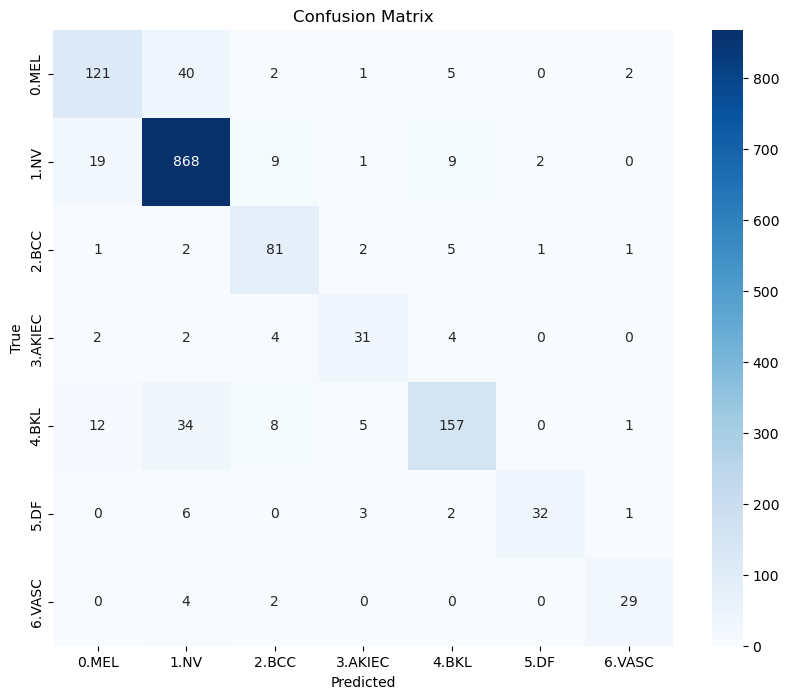


*** METRICHE DI CLASSIFICAZIONE ***
                       precision   recall   f1-score   support

0.MEL                   78.06     70.76       74.23      171.0
1.NV                    90.79     95.59       93.13      908.0
2.BCC                   76.42     87.10       81.41       93.0
3.AKIEC                 72.09     72.09       72.09       43.0
4.BKL                   86.26     72.35       78.70      217.0
5.DF                    91.43     72.73       81.01       44.0
6.VASC                  85.29     82.86       84.06       35.0

accuracy                            87.29

AUC Totale (Macro-Average): 0.9782
AUC Totale (Weighted-Average): 0.9705

ROC AUC per classe:
0.MEL               0.9504
1.NV                0.9718
2.BCC               0.9924
3.AKIEC             0.9897
4.BKL               0.9601
5.DF                0.9907
6.VASC              0.9925

Sensitivity per classe:
0.MEL               0.7076
1.NV                0.9559
2.BCC               0.8710
3.AKIEC             0.720

In [13]:
# Caricamento del modello per la classificazione multiclasse
device = args["device"]
model_path = os.path.join(args['save_dir'], 'model_best_test_bin+multi2.pt')

# Definisci il modello per la classificazione multiclasse
model = SwinClassification(num_classes_multiclass=args['num_classes'], num_classes_binary=2)
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)
model.eval()

# Inizializza i tensori per le predizioni e le etichette vere
predlist_test_multi = torch.zeros(0, dtype=torch.long, device='cpu')
labels_multi_multi = torch.zeros(0, dtype=torch.long, device='cpu')

# Probabilità per calcolo ROC e AUC
proba_test_multi = torch.zeros(0, device='cpu')

# Esegui il test senza gradiente
with torch.no_grad():
    for i, (inputs, labels_multi, labels_bin) in enumerate(test_loader):  # Usa test_loader per la classificazione
        inputs = inputs.to(device)
        labels_multi = labels_multi.to(device)

        # Ottieni le predizioni del modello
        multiclass_output, _ = model(inputs)  # Prendi solo l'output multiclasse
        preds_multi = torch.argmax(multiclass_output, dim=1)  # Predizione della classe
        proba_test_multi = torch.cat([proba_test_multi, multiclass_output.softmax(dim=1).cpu()])
        
        # Append batch prediction results
        predlist_test_multi = torch.cat([predlist_test_multi, preds_multi.view(-1).cpu()])
        labels_multi_multi = torch.cat([labels_multi_multi, labels_multi.view(-1).cpu()])

# Conversione dei tensori in numpy per l'elaborazione successiva
predlist_test_multi = predlist_test_multi.numpy()
labels_multi_multi = labels_multi_multi.numpy()
proba_test_multi = proba_test_multi.numpy()

# Confusion Matrix per la classificazione multiclasse
conf_matrix = confusion_matrix(labels_multi_multi, predlist_test_multi)

# Definisci i nomi delle classi per la classificazione multiclasse
class_names = ['0.MEL', '1.NV', '2.BCC', '3.AKIEC', '4.BKL', '5.DF', '6.VASC']

# Plot della confusion matrix
cm_save_path = os.path.join(args['save_dir'], 'Test_confusion_matrix.png')
plot_confusion_matrix(conf_matrix, class_names, save_path=cm_save_path)

# Calcolo delle metriche: ROC, AUC, Sensitivity e Specificity
roc_auc_dict = {}
sensitivity_dict = {}
specificity_dict = {}

for i, class_name in enumerate(class_names):
    y_true = (labels_multi_multi == i).astype(int)  # Verità per la classe corrente (one-vs-all)
    y_score = proba_test_multi[:, i]  # Probabilità per la classe corrente
    
    # ROC AUC
    if len(set(y_true)) > 1:  # Calcola solo se ci sono sia 0 che 1 nella classe
        roc_auc_dict[class_name] = roc_auc_score(y_true, y_score)
    
    # Sensitivity e Specificity
    y_pred = (predlist_test_multi == i).astype(int)
    sensitivity, specificity = calculate_sensitivity_specificity(y_true, y_pred)
    sensitivity_dict[class_name] = sensitivity
    specificity_dict[class_name] = specificity

# Calcolo delle AUC totali (macro e weighted)
y_true_binarized = label_binarize(labels_multi_multi, classes=list(range(len(class_names))))  # Binarizza i target
auc_macro = roc_auc_score(y_true_binarized, proba_test_multi, average="macro", multi_class="ovr")
auc_weighted = roc_auc_score(y_true_binarized, proba_test_multi, average="weighted", multi_class="ovr")

# Report di classificazione
report = classification_report(labels_multi_multi, predlist_test_multi, target_names=class_names, output_dict=True)

# Formattazione del report
formatted_report = "                       precision   recall   f1-score   support\n\n"
for class_name in class_names:
    precision = format_percentage(report[class_name]['precision'])
    recall = format_percentage(report[class_name]['recall'])
    f1_score = format_percentage(report[class_name]['f1-score'])
    support = report[class_name]['support']
    formatted_report += f"{class_name:<20}{precision:>9}    {recall:>6}    {f1_score:>8}   {support:>8}\n"

# Aggiungi le medie, l'accuratezza e le AUC totali
accuracy = format_percentage(report['accuracy'])
formatted_report += f"\naccuracy                           {accuracy:>6}\n"
formatted_report += f"\nAUC Totale (Macro-Average): {auc_macro:.4f}\n"
formatted_report += f"AUC Totale (Weighted-Average): {auc_weighted:.4f}\n"

# Aggiungi ROC AUC, Sensitivity e Specificity
formatted_report += "\nROC AUC per classe:\n"
for class_name, auc_value in roc_auc_dict.items():
    formatted_report += f"{class_name:<20}{auc_value:.4f}\n"

formatted_report += "\nSensitivity per classe:\n"
for class_name, sensitivity in sensitivity_dict.items():
    formatted_report += f"{class_name:<20}{sensitivity:.4f}\n"

formatted_report += "\nSpecificity per classe:\n"
for class_name, specificity in specificity_dict.items():
    formatted_report += f"{class_name:<20}{specificity:.4f}\n"

# Stampa diretta delle metriche
print("\n*** METRICHE DI CLASSIFICAZIONE ***")
print(formatted_report)

# Salva il report in un file
report_path = os.path.join(args['save_dir'], 'Test_classification_report.txt')
with open(report_path, 'w') as f:
    f.write(formatted_report)
print(f"Report salvato in: {report_path}")

# ROC per ogni classe
plt.figure(figsize=(12, 8))
for i, class_name in enumerate(class_names):
    y_true = (labels_multi_multi == i).astype(int)
    y_score = proba_test_multi[:, i]
    
    if len(set(y_true)) > 1:  # Calcola solo se ci sono sia 0 che 1 nella classe
        fpr, tpr, _ = roc_curve(y_true, y_score)
        plt.plot(fpr, tpr, label=f"{class_name} (AUC = {roc_auc_dict[class_name]:.4f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonale
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve per Classe')
plt.legend(loc='lower right')

# Salva il plot per le classi
roc_classes_path = os.path.join(args['save_dir'], 'Test_roc_curve_classes.png')
plt.savefig(roc_classes_path)
plt.close()
print(f"ROC Curve per classe salvata in: {roc_classes_path}")

# Macro e Weighted ROC
plt.figure(figsize=(12, 8))

# Macro-Average Curve
fpr_macro = np.linspace(0, 1, 100)
tpr_macro = np.zeros_like(fpr_macro)
for i in range(len(class_names)):
    y_true = (labels_multi_multi == i).astype(int)
    y_score = proba_test_multi[:, i]
    
    if len(set(y_true)) > 1:
        fpr, tpr, _ = roc_curve(y_true, y_score)
        tpr_interp = np.interp(fpr_macro, fpr, tpr)  # Interpolazione
        tpr_macro += tpr_interp
tpr_macro /= len(class_names)
auc_macro_curve = auc(fpr_macro, tpr_macro)
plt.plot(fpr_macro, tpr_macro, 'r--', label=f"Macro-Average ROC (AUC = {auc_macro_curve:.4f})")

# Weighted-Average Curve
fpr_weighted = np.linspace(0, 1, 100)
tpr_weighted = np.zeros_like(fpr_weighted)
weights = [sum(labels_multi_multi == i) for i in range(len(class_names))]  # Numero di esempi per classe

for i in range(len(class_names)):
    y_true = (labels_multi_multi == i).astype(int)
    y_score = proba_test_multi[:, i]
    
    if len(set(y_true)) > 1:
        fpr, tpr, _ = roc_curve(y_true, y_score)
        tpr_interp = np.interp(fpr_weighted, fpr, tpr)  # Interpolazione
        tpr_weighted += tpr_interp * weights[i]
tpr_weighted /= sum(weights)
auc_weighted_curve = auc(fpr_weighted, tpr_weighted)
plt.plot(fpr_weighted, tpr_weighted, 'g--', label=f"Weighted-Average ROC (AUC = {auc_weighted_curve:.4f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonale
plt.xlabel('Specificity')
plt.ylabel('Sensitivity')
plt.title('Macro e Weighted ROC Curve')
plt.legend(loc='lower right')

# Salva il plot per Macro e Weighted
roc_macro_weighted_path = os.path.join(args['save_dir'], 'Test_roc_curve_macro_weighted.png')
plt.savefig(roc_macro_weighted_path)
plt.close()
print(f"Macro e Weighted ROC Curve salvata in: {roc_macro_weighted_path}")

# t-SNE to represent multidimensional samples in 2D

In [ ]:
def validate_tsne(model, val_loader, device):
    print('Start validation...')
    model.eval()

    all_labels = []
    all_features = []
    with torch.no_grad():
        for inputs, labels_multi, labels_bin in tqdm(val_loader):
            inputs = inputs.to(device)

            multiclass_output, binary_output = model(inputs)
            features = model.features

            all_labels.extend(labels_multi.cpu().numpy())
            all_features.extend(features.cpu().numpy())
            #print("all_features:", len(all_features))

    return np.array(all_labels), np.array(all_features)

In [ ]:
device = args["device"]
model_path = os.path.join(args['save_dir'], 'model_best_test.pt')
model.load_state_dict(torch.load(model_path, map_location=device))
model = model.to(device)

In [ ]:
# Definire una funzione hook per memorizzare le features
def hook_fn(module, input, output):
    # Memorizza l'input (features in input al layer)
    model.features = input[0]

# Registrare l'hook al layer desiderato (in questo caso, il layer finale self.base)
hook = model.dropout.register_forward_hook(hook_fn)

In [ ]:
all_labels, all_features = validate_tsne(model, test_loader, device)

In [ ]:
df = pd.DataFrame(all_features) # data.data, columns=data.feature_names)
labels = all_labels

## Fit t-SNE

In [ ]:
# Initialize t-SNE with appropriate parameters
tsne = TSNE(n_components=2, perplexity=30, n_iter=1000, random_state=0)

# Fit and transform the data
tsne_results = tsne.fit_transform(df)

 ## Show results

In [ ]:
class_names = list(class_mapping.keys())
colors = plt.cm.tab10(range(7))
markers = ['>', 'o', '>', '>', 'o', 'o', 'o'] 

# Create a DataFrame for the results
tsne_df = pd.DataFrame(tsne_results, columns=['TSNE1', 'TSNE2'])
tsne_df['label'] = labels

plt.figure(figsize=(10, 8))

for i, class_name in enumerate(class_names):
    # Filtra i dati per la classe corrente
    subset = tsne_df[tsne_df['label'] == i]
    plt.scatter(subset['TSNE1'], subset['TSNE2'], c=[colors[i]], marker=markers[i], label=class_name)

# Aggiungi la legenda
plt.legend()
plt.xlabel('TSNE1')
plt.ylabel('TSNE2')
plt.title('t-SNE visualization of Melanoma dataset')
plt.show()